# Machine Learning & cryo-EM - Hole Selection Process
**Contributors**: 2023-2024 Intern Group from WEHI RCP Cryo-EM Research.

**Supervisor**: Rowland Mosbergen

**Project Goal**: Utilising unspervised machine learning technique to facilitate the particle picking process by selecting holes of good quality.

This notebook is designed to outline the process of selecting holes, covering the following aspects:
1. Manual Selection Techniques
2. Dividing the Mesh into Smaller Squares
3. Utilising the K-means Clustering Algorithm

## 1. Manual Selection
In this section, we will:
- Perform some manual manipulation to filter out holes that are at the edges and are not complete.

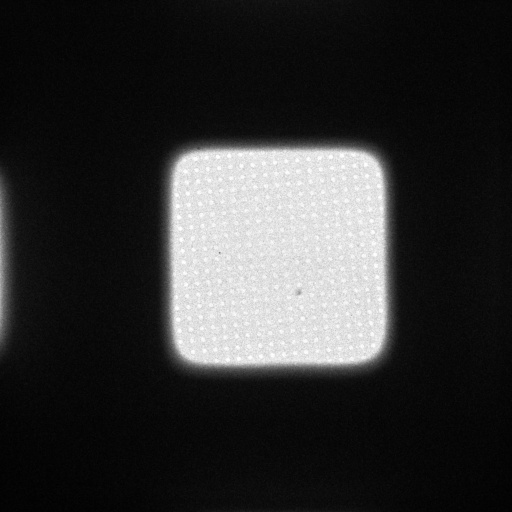

In [11]:
from PIL import Image
import numpy as np


IMG_NAME = 'GridSquare_20220302_182142'
img_path = f'../data/raw/{IMG_NAME}.jpg'
img = Image.open(img_path)
img

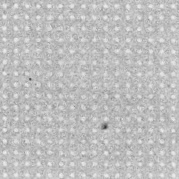

In [12]:
# Load the image
img_path = f'../data/curated/{IMG_NAME}.jpg'
img = Image.open(img_path)
img


## 2. Slice Mesh into Small Squares
In this section we will:
- Manually identify how many holes are there (16*16).
- Slice the mesh into small squares where each square contains one hole.

In [13]:
from PIL import Image
import numpy as np
#from google.colab import files
import os


# Load the image
#img = Image.open(filename)

# Define the size of each square -
square_size = img.width // 16  # This will divide the image width into 16 parts

# Calculate the number of squares along the width and height
num_squares_w = img.width // square_size
num_squares_h = img.height // square_size

# Ensure that we are slicing into 16x16 squares
assert num_squares_w == 16 and num_squares_h == 16, "Image cannot be divided into 16x16 squares with the current square size."

# Create a directory to save the slices
slices_dir = f'../data/curated/slices_{IMG_NAME}'
os.makedirs(slices_dir, exist_ok=True)

# Slice and save the image
for i in range(num_squares_h):
    for j in range(num_squares_w):
        # Define the coordinates of the current square
        left = j * square_size
        upper = i * square_size
        right = (j + 1) * square_size
        lower = (i + 1) * square_size
        # Crop the current square
        img_slice = img.crop((left, upper, right, lower))
        # Save the slice
        img_slice.save(f'{slices_dir}/slice_{i*num_squares_w + j}.png')



## 3.K-means Algorithm
We will apply unspervised machine learning k-means algorithm to cluster the sliced images into 3 groups:
- thin ice
- good ice
- thick ice

In [15]:
import numpy as np
from sklearn.cluster import KMeans
from PIL import Image
from matplotlib import pyplot as plt
import os

slices_dir = f'../data/curated/slices_{IMG_NAME}'

# Load all the images and convert them into a feature vector
features = []
for file_name in sorted(os.listdir(slices_dir)):
    if file_name.endswith('.png'):
        img = Image.open(os.path.join(slices_dir, file_name))
        feature = np.array(img).flatten()  # Flatten the image to create a feature vector
        features.append(feature)

# Convert the list of features into a numpy array
features = np.array(features)

# Apply K-means clustering
kmeans = KMeans(n_clusters=2, random_state=0).fit(features)

clusters = kmeans.labels_

/Users/graceliu/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


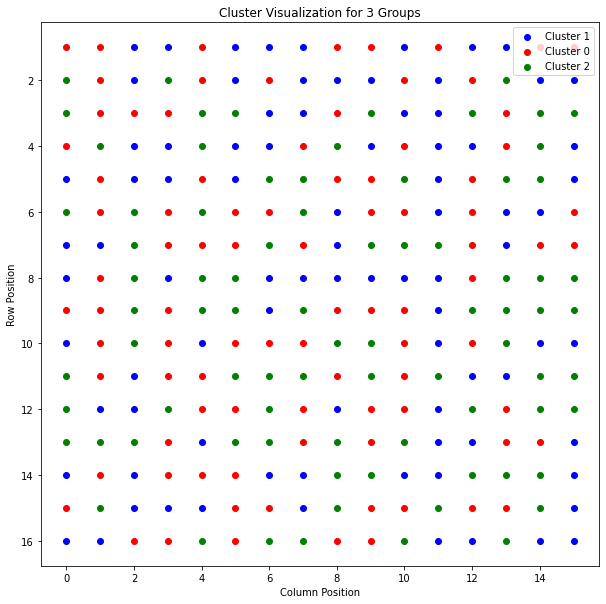

In [31]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Placeholder variables, ensure these are correctly defined in your actual code
slices_dir = f'../data/curated/slices_{IMG_NAME}'
clusters = [np.random.randint(0, 3) for _ in range(256)]  # Example cluster assignments for 256 slices
IMG_NAME = 'GridSquare_20220302_182142'

def plot_clusters_and_process_images():
    # Generate and plot clusters
    original_positions = [(i, j, np.random.randint(0, 3)) for i in range(16) for j in range(16)]
    plt.figure(figsize=(10, 10))
    # Dictionary for color and label mapping
    cluster_info = {0: ('red', 'Cluster 0'), 1: ('blue', 'Cluster 1'), 2: ('green', 'Cluster 2')}
    plotted_labels = set()
    
    for pos in original_positions:
        color, label = cluster_info[pos[2]]
        if label not in plotted_labels:
            plt.scatter(pos[1], 16-pos[0], c=color, marker='o', label=label)
            plotted_labels.add(label)
        else:
            plt.scatter(pos[1], 16-pos[0], c=color, marker='o')

    plt.legend()
    plt.gca().invert_yaxis()
    plt.title('Cluster Visualization for 3 Groups')
    plt.xlabel('Column Position')
    plt.ylabel('Row Position')
    plt.show()

    # Process image slices
    features, file_names = [], []
    for file_name in sorted(os.listdir(slices_dir)):
        if file_name.endswith('.png'):
            file_names.append(file_name)
            img = Image.open(os.path.join(slices_dir, file_name))
            features.append(np.array(img).flatten())

    # Prepare and write data to text file
    data_to_write = []
    for idx, (file_name, cluster_label) in enumerate(zip(file_names, clusters)):
        row, col = divmod(idx, 16)  # Assumes a 16x16 grid
        data_to_write.append(f"{file_name}, ({row}, {col}), {cluster_label}")
    
    output_txt_path = f'../data/curated/slices_{IMG_NAME}/positions.txt'
    with open(output_txt_path, 'w') as f:
        for line in data_to_write:
            f.write(line + '\n')

# Call the function
plot_clusters_and_process_images()


### ### Save Position & Example of Position.txt file.

slice_0.png, (0, 0), 2

slice_1.png, (0, 1), 1

slice_10.png, (0, 2), 0

slice_100.png, (0, 3), 1

slice_101.png, (0, 4), 0

slice_102.png, (0, 5), 2

slice_103.png, (0, 6), 1

slice_104.png, (0, 7), 1

\